In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from timeit import default_timer
start = default_timer()
#plt.style.use('ggplot')

import scipy.sparse as sp
from scipy.sparse.linalg import svds
import itertools
from sklearn.metrics import confusion_matrix

import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature




ImportError: cannot import name 'signature' from 'sklearn.utils.fixes' (C:\Users\SHELLA\Anaconda3\lib\site-packages\sklearn\utils\fixes.py)

In [63]:
def coverage(predicted, catalog):
    """
    Computes the coverage for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    Returns
    ----------
    coverage:
        The coverage of the recommendations as a percent
        rounded to 2 decimal places
    """
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
    return coverage

def _ark(actual, predicted, k=10):
    """
    Computes the average recall at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : int
        The average recall at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / len(actual)

def mark(actual, predicted, k=10):
    """
    Computes the mean average recall at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: int
            The mean average recall at k (mar@k)
    """
    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])

def personalization(predicted):
    """
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.
    """

    def make_rec_matrix(predicted, unique_recs):
        rec_matrix = pd.DataFrame(index = range(len(predicted)),columns=unique_recs)
        rec_matrix.fillna(0, inplace=True)
        for i in rec_matrix.index:
            rec_matrix.loc[i, predicted[i]] = 1
        return rec_matrix

    #get all unique items recommended
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_recs = list(set(predicted_flattened))

    #create matrix for recommendations
    rec_matrix = make_rec_matrix(predicted, unique_recs)
    rec_matrix_sparse = sp.csr_matrix(rec_matrix.values)

    #calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity
    personalization = np.mean(similarity[upper_right])
    return 1-personalization

def _single_list_similarity(predicted, feature_df):
    """
    Computes the intra-list similarity for a single list of recommendations.
    Parameters
    ----------
    predicted : a list
        Ordered predictions
        Example: ['X', 'Y', 'Z']
    feature_df: dataframe
        A dataframe with one hot encoded or latent features.
        The dataframe should be indexed by the id used in the recommendations.
    Returns:
    -------
    ils_single_user: float
        The intra-list similarity for a single list of recommendations.
    """
    #get features for all recommended items
    recs_content = feature_df.loc[predicted]
    recs_content = recs_content.dropna()
    recs_content = sp.csr_matrix(recs_content.values)

    #calculate similarity scores for all items in list
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

def intra_list_similarity(predicted, feature_df):
    """
    Computes the average intra-list similarity of all recommendations.
    This metric can be used to measure diversity of the list of recommended items.
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        Example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    feature_df: dataframe
        A dataframe with one hot encoded or latent features.
        The dataframe should be indexed by the id used in the recommendations.
    Returns:
    -------
        The average intra-list similarity for recommendations.
    """
    feature_df = feature_df.fillna(0)
    Users = range(len(predicted))
    ils = [_single_list_similarity(predicted[u], feature_df) for u in Users]
    return np.mean(ils)

def mse(y, yhat):
    """
    Computes the mean square error (MSE)
    Parameters
    ----------
    yhat : Series or array. Reconstructed (predicted) ratings or interaction values.
    y: original true ratings or interaction values.
    Returns:
    -------
        The mean square error (MSE)
    """
    mse = mean_squared_error(y, yhat)
    return mse

def make_confusion_matrix(y, yhat):
    """
    Calculates and plots a confusion matrix
    Parameters
    ----------
    y : list or array of actual interaction values such as ratings
    yhat: list or array of actual predicted interaction values
    Returns:
    -------
        A confusion matrix plot
    """
    cm = confusion_matrix(y, yhat, labels=[1,0])
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100

    fmt = ".2f"
    thresh = cm.max() / 2.
    descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
    colors = np.array([["green", "red"], ["red", "green"]])
    plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt)+'%\n' + descriptions[i, j],
                     horizontalalignment="center",
                     color=colors[i,j])
    plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
    plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.xticks([0,1], [1,0], rotation=45)
    plt.yticks([0,1], [1,0])
    plt.show()


def recommender_precision(predicted, actual):
    """
    Computes the precision of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        precision: int
    """
    def calc_precision(predicted, actual):
        prec = [value for value in predicted if value in actual]
        prec = np.round(float(len(prec)) / float(len(predicted)), 4)
        return prec

    precision = np.mean(map(calc_precision, predicted, actual))
    return precision


def recommender_recall(predicted, actual):
    """
    Computes the recall of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        recall: int
    """
    def calc_recall(predicted, actual):
        reca = [value for value in predicted if value in actual]
        reca = np.round(float(len(reca)) / float(len(actual)), 4)
        return reca

    recall = np.mean(map(calc_recall, predicted, actual))
    return recall

In [64]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    interaction_type: str
        type of user-item interactions
        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
    """
    #calculate cumulative volumes
    volume_df = pd.DataFrame(df[item_id_column].value_counts())
    volume_df.reset_index(inplace=True)
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df.percent_of_total_volume <= percentage]
        tail = volume_df[volume_df.percent_of_total_volume > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()


def coverage_plot(coverage_scores, model_names):
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

def mark_plot(mark_scores, model_names, k_range):
    """
    Plots the mean average recall at k for a set of models to compare.
    ----------
    mark_scores: list of lists
        list of list of mar@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A mar@k plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')

    plt.show()


def mapk_plot(mapk_scores, model_names, k_range):
    """
    Plots the mean average precision at k for a set of models to compare.
    ----------
    mapk_scores: list of lists
        list of list of map@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A map@k plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')
    plt.show()



def class_separation_plot(pred_df, n_bins=150, threshold=None, figsize=(10,6), title=None):
    """
    Plots the predicted class probabilities for multiple classes.
    Usefull for visualizing predicted interaction values such as 5 star ratings, where a "class" is a star rating,
    or visualizing predicted class probabilities for binary classification model or recommender system.
    The true class states are colored.
    ----------
    pred_df: pandas dataframe
        a dataframe containing a column of predicted interaction values or classification probabilites,
        and a column of true class 1 and class 0 states.
        This dataframe must contain columns named "predicted" and "truth"
        example:
        	predicted | truth
        	5.345345	|  5
        	2.072020	|  2
    n_bins: number of bins for histogram.
    threshold: float. default = 0.5
        A single number between 0 and 1 identifying the threshold to classify observations to class
        example: 0.5
    figsize: size of figure
    title: plot title
    Returns:
    -------
        A classification probability plot
    """
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF", "#FC5FA3"]
    classes = pred_df.truth.unique()
    plt.figure(figsize=figsize)
    for i in range(len(classes)):
        single_class = classes[i]
        sns.distplot( pred_df.query("truth == @single_class")["predicted"] , bins=n_bins, color=recommender_palette[i], label="True {}".format(single_class))
    plt.legend()
    if threshold == None: pass
    else: plt.axvline(threshold, color="black", linestyle='--')
    plt.xlabel("Predicted value")
    plt.ylabel("Frequency")
    if title == None: plt.title(" ")
    else: plt.title(title)
    plt.show()


def roc_plot(actual, model_probs, model_names, figsize=(10,10)):
    """
    Receiver Operating Characteristic Plot. Can plot multiple models.
    ----------
    actual: array of dataframe of true classes assignements.
        example:
        [1,1,0,1,0]
    model_probs: list of arrays
        a list containing classification probabilites for each model in order.
        example:
        model_probs = [class_probs_1, class_probs_2]
    model_names: list of strings
        a list containing names for each model in order.
        example:
        model_names = ["GBT", "Logistic Regression"]
    figsize: size of figure
    Returns:
    -------
        Receiver Operating Characteristic Plot with AUC in the legend.
    """
    model_names = make_listy(model_names)
    if not is_listy(model_probs): model_probs = [model_probs]

    if len(model_names) > 5:
        return ValueError("Can only compare 5 models or less.")

    colors = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_title('Receiver Operating Characteristic Plot')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    for m in range(len(model_names)):
        fpr, tpr, threshold = roc_curve(actual, model_probs[m])
        roc_auc = auc(fpr, tpr)
        ax = sns.lineplot(x=fpr,
                          y=tpr,
                          lw=2,
                          color=colors[m],
                          label = model_names[m] + ' AUC = %0.4f' % roc_auc)
    plt.show()


def precision_recall_plot(targs, preds, figsize=(6,6)):
    """
    Plots the precision recall curve
    ----------
    targs: array-like true class labels
    preds: array-like predicted probabilities
    figsize: size of figure
    Returns:
    -------
        A precision and recall curve
    """
    average_precision = average_precision_score(targs, preds)
    precision, recall, _ = precision_recall_curve(targs, preds)
    plt.figure(figsize=figsize)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
        average_precision))
    plt.show()


def make_listy(p):
    if isinstance(p, str): return [p]
    try:
        _ = iter(p)
    except TypeError:
        p = [p]
    return p


def is_listy(x): return isinstance(x, (tuple,list))

In [149]:
movies = pd.read_csv('ml-20m/movies.csv')
ratings = pd.read_csv('ml-20m/ratings.csv')

In [150]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

In [151]:
# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

In [152]:
no_genres_listed = movies[['movieId', '(no genres listed)']]
movies = movies.drop(columns=['(no genres listed)'])
genres_unique = genres_unique.drop(index=19)

In [153]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

In [154]:
num_users = ratings.userId.unique().shape[0]
num_movies = ratings.movieId.unique().shape[0]
print(str(num_users) + ' Users')
print(str(num_movies) + ' Movies')

138493 Users
26744 Movies


In [155]:
def loadMovieNames():
    movieNames = {}
    for index, field in movies.iterrows():
        movieNames[int(field['movieId'])] = field['title']
    return movieNames
nameDict = loadMovieNames()

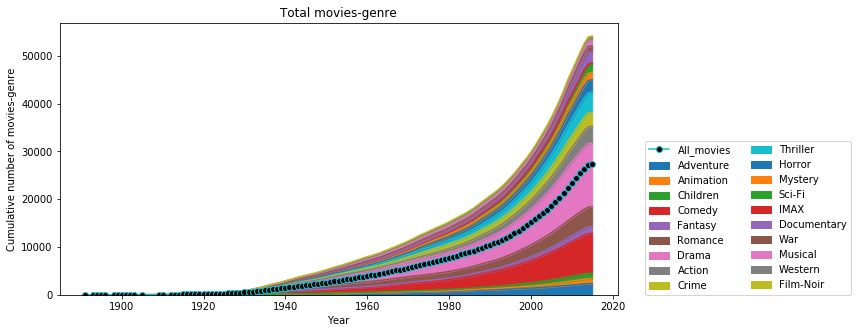

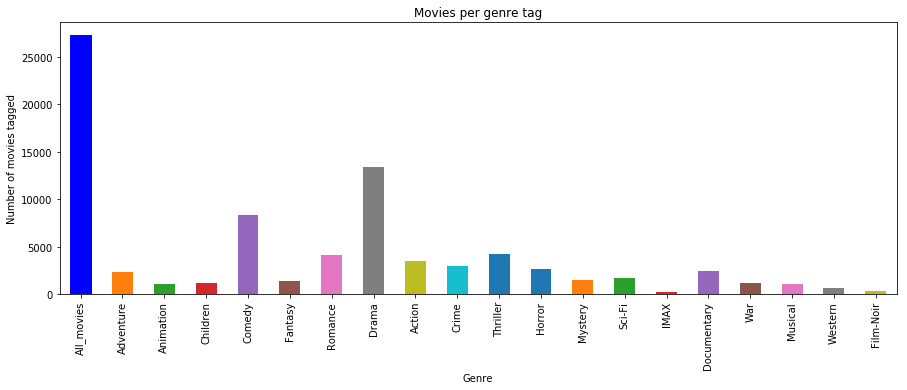

Elapsed time(sec):  1.31


In [21]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))


### Popularity

In [19]:
overallpopularity = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
overallpopularity.index = overallpopularity.index.map(lambda x: nameDict[x])
overallpopularity.index.name = 'movie'
overallpopularity.head()

movie
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: rating, dtype: int64

In [24]:
for genre in genres_unique.genre:
    m_id = movies[movies[genre]]['movieId']
    g_rating = ratings[ratings['movieId'].isin(m_id)]
    popularity = g_rating.groupby('movieId')['rating'].count().sort_values(ascending=False)
    popularity.index = popularity.index.map(lambda x: nameDict[x])
    popularity.index.name = 'movie'
    print("The top 10 most popular " + genre +  " movies are: ")
    i = 0
    for m, p in popularity.iteritems():
        if i == 10:
            break
        print(str(m) + '\t' + str(p) + ' people have rated this movie')
        i += 1
    print('\n')

The top 10 most popular Adventure movies are: 
Jurassic Park (1993)	59715 people have rated this movie
Star Wars: Episode IV - A New Hope (1977)	54502 people have rated this movie
Toy Story (1995)	49695 people have rated this movie
Apollo 13 (1995)	47777 people have rated this movie
Independence Day (a.k.a. ID4) (1996)	47048 people have rated this movie
Star Wars: Episode VI - Return of the Jedi (1983)	46839 people have rated this movie
Star Wars: Episode V - The Empire Strikes Back (1980)	45313 people have rated this movie
Dances with Wolves (1990)	44208 people have rated this movie
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)	43295 people have rated this movie
True Lies (1994)	43159 people have rated this movie


The top 10 most popular Animation movies are: 
Toy Story (1995)	49695 people have rated this movie
Aladdin (1992)	41842 people have rated this movie
Lion King, The (1994)	38991 people have rated this movie
Beauty and the Beast (1991)	35138 p

### Subset of the data

In [76]:
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()
sub_ratings = ratings.query('userId in @users')
movies = sub_ratings.movieId.value_counts()
movies = movies[movies>n].index.tolist()
sub_ratings = sub_ratings.query('movieId in @movies')


In [77]:
num_users = sub_ratings.userId.unique().shape[0]
num_movies = sub_ratings.movieId.unique().shape[0]
print(str(num_users) + ' Users')
print(str(num_movies) + ' Movies')
print('sparsity level is {}%'.format(round((1.0 - len(sub_ratings)/float(num_users*num_movies))*100, 4)))

1884 Users
553 Movies
sparsity level is 30.7304%


#### Subset for cold start problem

In [506]:
m=60
users = ratings.userId.value_counts()
users = users[users<m].index.tolist()[:1000]
cs_ratings = ratings.query('userId in @users')


(897243, 4)

In [195]:
df.shape

(20000263, 4)

In [515]:
df = pd.merge(ratings[['userId', 'movieId', 'rating']], movies[['movieId', 'year']], on='movieId')

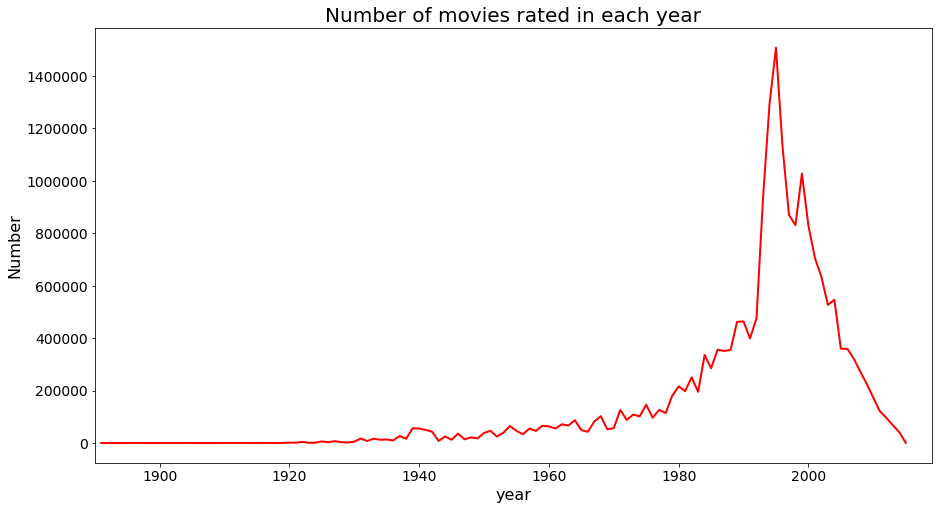

In [519]:
df.groupby('year').count()['movieId'].plot(figsize=(15,8),xlim=(1890,2019),fontsize=14,linewidth=2.0,c='r')
plt.ylabel('Number',fontsize=16)
plt.title("Number of movies rated in each year", fontsize=20)
plt.xlabel('year',fontsize=16)

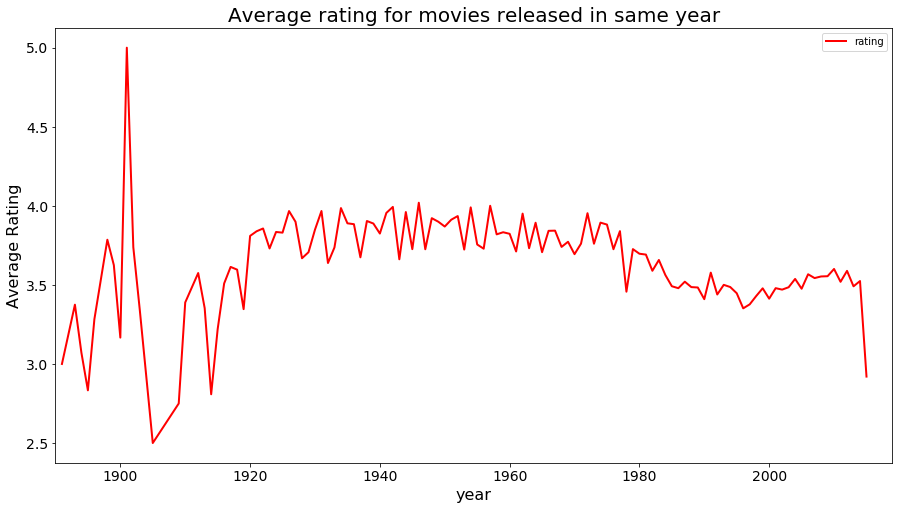

In [518]:
df[['rating', 'year']].groupby('year').mean().plot(figsize=(15,8),xlim=(1890,2019),fontsize=14,linewidth=2.0,c='r')
plt.ylabel('Average Rating', fontsize=16)
plt.title("Average rating for movies released in same year", fontsize=20)
plt.xlabel('year', fontsize=16)

### Popularity-based Model

In [323]:
popularity = sub_ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
most_pop = popularity.index[:20]

In [501]:
cs_ratings.shape

(1664505, 4)

In [507]:
R_origin = cs_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0).applymap(lambda x: 1 if x > 3 else 0)

In [508]:
def recall(movieid):
    like = R_origin[[movieid]][R_origin[movieid] == 1].index.tolist()
    correct = len(set(like).intersection(set(most_pop)))
    
    return correct / 20

In [509]:
tot_recall = 0
for movieid in R_origin.columns:
    tot_recall += recall(movieid)
tot_recall = tot_recall / (R_origin.shape[1] + 0.00001)
print("Popularity for total recall rate is " + str(tot_recall))

Popularity for total recall rate is 0.18524999814750007


### Item-based CF

In [79]:
# Initializing 
#cur_rating = sub_ratings.sort_values(by=['movieId'])
# pivot ratings for item-based cf
item_embeddings = sub_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

item_ratings = sub_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
)

# pivot ratings for user-based cf
user_embeddings = sub_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

user_ratings = sub_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)


In [80]:
class ItemCF(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, embeddings, rating_matrix):
        '''
        embeddings: item*user matrix
        rating_matrix: item*user matrix
        '''
        self.embeddings = embeddings
        self.rating_matrix = rating_matrix
        self.ids = embeddings.index.tolist()
        self.epsilon = 0.001

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        sub_rowmean = self.rating_matrix.sub(self.rating_matrix.mean(axis=1), axis=0).fillna(0)
        #sub_rowmean = self.embeddings
        self.similarity_matrix = pd.DataFrame(cosine_similarity(
            X=sub_rowmean),
            index=self.ids)
        self.similarity_matrix.columns = self.ids
        #return self.similarity_matrix
        print('Finish calculating similarity matrix')

    def predict_similar_items(self, seed_item, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_items = pd.DataFrame(self.similarity_matrix.loc[seed_item])
        similar_items.columns = ["similarity_score"]
        similar_items = similar_items.sort_values('similarity_score', ascending=False)
        similar_items = similar_items.head(n)
        similar_items.reset_index(inplace=True)
        similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
        return similar_items.to_dict()
    
    def rating_predict(self, seed_item, seed_user, k):
        similar_items = self.predict_similar_items(seed_item, k)
        mu = self.embeddings.mean().mean()
        bx = self.embeddings.loc[:, seed_user].mean() - mu
        bi = self.embeddings.loc[seed_item, :].mean() - mu
        num = sum([(similar_items['similarity_score'][str(i)] * (self.embeddings.loc[similar_items['item_id'][str(i)], seed_user] - bx - self.embeddings.loc[similar_items['item_id'][str(i)], :].mean() + mu)) for i in range(1, k)])
        den = sum(similar_items['similarity_score'].values())
        
        b_xi = mu + bx + bi
        
        return b_xi + num / (den + self.epsilon)
    
    #def rating_predict_matrix(self):
    #    rating = self.embeddings.values.T.dot(self.similarity_matrix.values)
    #    simsum = np.array([np.abs(self.similarity_matrix).sum(axis=1)])
    #    pred = pd.DataFrame(rating / (simsum + 0.001), columns=self.ids, index=self.embeddings.columns)
        
    #    return pred

In [81]:
class UserCF(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, embeddings, rating_matrix):
        '''
        embeddings: user*item matrix
        rating_matrix: user*item matrix
        '''
        self.embeddings = embeddings
        self.rating_matrix = rating_matrix
        self.ids = embeddings.index.tolist()
        self.epsilon = 0.001

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        sub_rowmean = self.rating_matrix.sub(self.rating_matrix.mean(axis=1), axis=0).fillna(0)
        #sub_rowmean = self.embeddings
        self.similarity_matrix = pd.DataFrame(cosine_similarity(
            X=sub_rowmean),
            index=self.ids)
        self.similarity_matrix.columns = self.ids
        #return self.similarity_matrix
        print('Finish calculating similarity matrix')

    def predict_similar_users(self, seed_user, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_users = pd.DataFrame(self.similarity_matrix.loc[seed_user])
        similar_users.columns = ["similarity_score"]
        similar_users = similar_users.sort_values('similarity_score', ascending=False)
        similar_users = similar_users.head(n)
        similar_users.reset_index(inplace=True)
        similar_users = similar_users.rename(index=str, columns={"index": "user_id"})
        return similar_users.to_dict()
    
    def rating_predict(self, seed_user, seed_item, k):
        similar_users = self.predict_similar_users(seed_user, k)
        mu = self.embeddings.mean().mean()
        bi = self.embeddings.loc[:, seed_item].mean() - mu
        bx = self.embeddings.loc[seed_user, :].mean() - mu
        num = sum([(similar_users['similarity_score'][str(i)] * (self.embeddings.loc[similar_users['user_id'][str(i)], seed_item] - bi - self.embeddings.loc[similar_users['user_id'][str(i)], :].mean() + mu)) for i in range(1, k)])
        den = sum(similar_users['similarity_score'].values())
        
        b_xi = mu + bx + bi
        
        return b_xi + num / (den + self.epsilon)
    
   # def rating_predict_matrix(self):
   #     rating = self.embeddings.values.T.dot(self.similarity_matrix.values)
   #     simsum = np.array([np.abs(self.similarity_matrix).sum(axis=1)])
   #     pred = pd.DataFrame(rating / (simsum + 0.001), columns=self.ids, index=self.embeddings.columns)
        
   #     return pred

In [85]:
def rmse(pred, actual):
    return math.sqrt(mean_squared_error(pred, actual))

#### Test set for CF

In [280]:
#test = item_embeddings.sample(frac=0.2, replace=False)
#movieid = test.index.tolist()
#test = test.sample(frac=0.2, replace=False, axis=1)
#userid = test.columns.tolist()
#test_ratings = sub_ratings[['movieId', 'userId', 'rating']][sub_ratings['userId'].isin(userid)]
#test_ratings = test_ratings[test_ratings['movieId'].isin(movieid)]

In [283]:
testset = sub_ratings[['userId', 'movieId', 'rating']].sample(frac=0.2, replace=False, random_state=1)
trainset = sub_ratings[['userId', 'movieId', 'rating']][~sub_ratings[['userId', 'movieId', 'rating']].index.isin(testset.index)]

#### Item-based CF

In [87]:
iembeddings = item_embeddings
iembeddings.loc[movieid, userid] = iembeddings.loc[movieid, userid].applymap(lambda x: 0)
itemcf = ItemCF(iembeddings, item_ratings)
itemcf.calculate_cosine_similarity_matrix()
test_ratings['item_pred'] = test_ratings.apply(lambda x: itemcf.rating_predict(x['movieId'], x['userId'], 15), axis=1)
rmse(test_ratings['item_pred'], test_ratings['rating'])

Finish calculating similarity matrix


1.1076071631465585

#### User-based CF

In [88]:
uembeddings = user_embeddings
uembeddings.loc[userid, movieid] = uembeddings.loc[userid, movieid].applymap(lambda x: 0)
usercf = UserCF(uembeddings, user_ratings)
usercf.calculate_cosine_similarity_matrix()
test_ratings['user_pred'] = test_ratings.apply(lambda x: usercf.rating_predict(x['userId'], x['movieId'], 15), axis=1)
rmse(test_ratings['user_pred'], test_ratings['rating'])

Finish calculating similarity matrix


1.1202641686009098

### Excluding Bias

In [288]:
class ItemCFwoBias(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, ratings):
        '''
        embeddings: item*user matrix
        rating_matrix: item*user matrix
        '''
        
        self.ratings = ratings
        self.embeddings = self.ratings.pivot(
                                index='movieId',
                                columns='userId',
                                values='rating'
                                            ).fillna(0)

        self.rating_matrix = self.ratings.pivot(
                            index='movieId',
                            columns='userId',
                            values='rating'
                                            )
        #self.embeddings = embeddings
        #self.rating_matrix = rating_matrix
        self.ids = self.embeddings.index.tolist()
        self.epsilon = 0.001

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        #sub_rowmean = self.rating_matrix.sub(self.rating_matrix.mean(axis=1), axis=0).fillna(0)
        sub_rowmean = self.embeddings
        self.similarity_matrix = pd.DataFrame(cosine_similarity(
            X=sub_rowmean),
            index=self.ids)
        self.similarity_matrix.columns = self.ids
        #return self.similarity_matrix
        print('Finish calculating similarity matrix')

    def predict_similar_items(self, seed_item, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_items = pd.DataFrame(self.similarity_matrix.loc[seed_item])
        similar_items.columns = ["similarity_score"]
        similar_items = similar_items.sort_values('similarity_score', ascending=False)
        similar_items = similar_items.head(n)
        similar_items.reset_index(inplace=True)
        similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
        return similar_items.to_dict()
    
    def rating_predict(self, seed_item, seed_user, k):
        self.k = k
        similar_items = self.predict_similar_items(seed_item, k)
        #mu = self.embeddings.mean().mean()
        #bx = self.embeddings.loc[:, seed_user].mean() - mu
        #bi = self.embeddings.loc[seed_item, :].mean() - mu
        num = sum([(similar_items['similarity_score'][str(i)] * self.embeddings.loc[similar_items['item_id'][str(i)], seed_user]) for i in range(1, k)])
        den = sum(similar_items['similarity_score'].values())
        
        #b_xi = mu + bx + bi
        #return b_xi + num / (den + self.epsilon)
        return num / (den + self.epsilon)
    def recommend(self, user, k):
        '''Recommend top k movies that user might like most'''
        
        item = ratings['movieId'].drop_duplicates()
        item['pred'] = item['movieId'].apply(lambda x: self.rating_predict(x['movieId'], user, self.k), axis=1)
        item.sort_values(by='pred', ascending=False, inplace=True)
        topid = item['movieId'][:k].values.flatten().tolist()
        return list(map(lambda x: nameDict[x], topid))
        
        
        
        

In [289]:
itemcfwobias = ItemCFwoBias(trainset)
itemcfwobias.calculate_cosine_similarity_matrix()

Finish calculating similarity matrix


In [290]:
ibtest_ratings = testset
ibtest_ratings['item_pred'] = ibtest_ratings.apply(lambda x: itemcfwobias.rating_predict(x['movieId'], x['userId'], 15), axis=1)
rmse(ibtest_ratings['item_pred'], ibtest_ratings['rating'])

1.3256999461146088

In [291]:
class UserCFwoBias(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, ratings):
        '''
        embeddings: user*item matrix
        rating_matrix: user*item matrix
        '''
        self.ratings = ratings
        self.embeddings = ratings.pivot(
                                index='userId',
                                columns='movieId',
                                values='rating'
                                            ).fillna(0)

        self.rating_matrix = ratings.pivot(
                            index='userId',
                            columns='movieId',
                            values='rating'
                                            )
        #self.embeddings = embeddings
        #self.rating_matrix = rating_matrix
        self.ids = self.embeddings.index.tolist()
        self.epsilon = 0.001

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        #sub_rowmean = self.rating_matrix.sub(self.rating_matrix.mean(axis=1), axis=0).fillna(0)
        sub_rowmean = self.embeddings.fillna(0)
        self.similarity_matrix = pd.DataFrame(cosine_similarity(
            X=sub_rowmean),
            index=self.ids)
        self.similarity_matrix.columns = self.ids
        #return self.similarity_matrix
        print('Finish calculating similarity matrix')

    def predict_similar_users(self, seed_user, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_users = pd.DataFrame(self.similarity_matrix.loc[seed_user])
        similar_users.columns = ["similarity_score"]
        similar_users = similar_users.sort_values('similarity_score', ascending=False)
        similar_users = similar_users.head(n)
        similar_users.reset_index(inplace=True)
        similar_users = similar_users.rename(index=str, columns={"index": "user_id"})
        return similar_users.to_dict()
    
    def rating_predict(self, seed_user, seed_item, k):
        similar_users = self.predict_similar_users(seed_user, k)
        #mu = self.embeddings.mean().mean()
        #bi = self.embeddings.loc[:, seed_item].mean() - mu
        #bx = self.embeddings.loc[seed_user, :].mean() - mu
        num = sum([(similar_users['similarity_score'][str(i)] * self.embeddings.loc[similar_users['user_id'][str(i)], seed_item]) for i in range(1, k)])
        den = sum(similar_users['similarity_score'].values())
        
        #b_xi = mu + bx + bi
        #return b_xi + num / (den + self.epsilon)
        
        return num / (den + self.epsilon)

In [292]:
usercfwobias = UserCFwoBias(trainset)
usercfwobias.calculate_cosine_similarity_matrix()
ubtest_ratings = testset
ubtest_ratings['user_pred'] = ubtest_ratings.apply(lambda x: usercfwobias.rating_predict(x['userId'], x['movieId'], 15), axis=1)
rmse(ubtest_ratings['user_pred'], ubtest_ratings['rating'])



Finish calculating similarity matrix


1.5044588803546677

#### SVD

In [89]:
def matrix_rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return math.sqrt(mean_squared_error(prediction, ground_truth))

In [482]:
testset = sub_ratings[['userId', 'movieId', 'rating']].sample(frac=0.2, replace=False, random_state=1)
trainset = sub_ratings[['userId', 'movieId', 'rating']][~sub_ratings[['userId', 'movieId', 'rating']].index.isin(testset.index)]
#valset = trainset.sample(frac=0.25, replace=False, random_state=1)
#trainset = trainset[~trainset.index.isin(valset.index)]

In [91]:
print(testset.shape)
#print(valset.shape)
print(trainset.shape)
print(sub_ratings.shape)

(144337, 3)
(577350, 3)
(721687, 4)


In [483]:
train_matrix = trainset.pivot(index='userId', columns='movieId', values='rating')
#val_matrix = valset.pivot(index='userId', columns='movieId', values='rating')
test_matrix = testset.pivot(index='userId', columns='movieId', values='rating')

In [93]:
%time u, s, vt = svds(train_matrix.fillna(0).values, k = 10)#tweak k, dimensionality for rank matrix
%time s_diag_matrix=np.diag(s)
%time X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

CPU times: user 153 ms, sys: 12.3 ms, total: 165 ms
Wall time: 104 ms
CPU times: user 537 µs, sys: 393 µs, total: 930 µs
Wall time: 626 µs
CPU times: user 8.74 ms, sys: 669 µs, total: 9.41 ms
Wall time: 4.99 ms


In [94]:
print ('matrix-factorization SVD RMSE: %.2f' %matrix_rmse(X_pred, test_matrix.fillna(0).values))


matrix-factorization SVD RMSE: 1.58


#### Matrix Factorization with SGD

In [95]:
# R = QP.T
def prediction(Q,P):
    return Q.dot(P.T)

In [173]:
class LFM(object):
    ''' This class built a recommender system based on latent factor model with 
    stochastic gradient descent'''
    
    def __init__(self, train, test):
        self.ids = train.index
        self.columns = train.columns
        self.R = train.fillna(0).values
        self.T = test.fillna(0).values
        self.Q = None
        self.P = None
    
    def initialize(self, Q=None, P=None, k=1):
        '''initialize Q, P and latent factor k. The default values for Q and P
        are the results for SVD for R'''
        if (Q is not None) and (P is not None):
            self.Q = Q
            self.P = P
        else:
            u, s, vt = svds(self.R, k=k)
            s_diag=np.diag(s)
            self.Q = u
            self.P = s_diag.dot(vt).T
            
    def rmse_(self, R, Q, P):
       # prediction = Q.dot(P.T)
       # prediction = prediction[R.nonzero()].flatten() 
       # true_value = R[R.nonzero()].flatten()
       # return math.sqrt(mean_squared_error(prediction, true_value))
        I = R != 0  # Indicator function which is zero for missing data
        ME = I * (R - np.dot(Q, P.T))  # Errors between real and predicted ratings
        MSE = ME**2  
        return np.sqrt(np.sum(MSE)/np.sum(I))
    
    def train(self, lr1, lr2, reg1, reg2, maxiter):
        '''SGD for training
        @lr1: learning rate for Q   @lr2: learning rate for P
        @reg1: regularizer for Q    @reg2: regularizer for P
        @maxiter: stop when epochs exceed this value
        '''
        
        train_errors = []
        test_errors = []
        users,items = self.R.nonzero() 
        for epoch in range(maxiter):
            dR = 2 * (self.R - self.Q.dot(self.P.T))
            start_time = default_timer()
            for u, i in zip(users, items):
                dq = dR[u, i] * self.P[i, :] - 2 * reg2 * self.Q[u, :]
                self.Q[u, :] += lr1 * dq
                dp = dR[u, i] * self.Q[u, :] - 2 * reg1 * self.P[i, :]
                self.P[i, :] += lr2 * dp
            
            trg_err = self.rmse_(self.R, self.Q, self.P)
            print("current training error: " + str(trg_err))
            train_errors = train_errors + [trg_err]
            test_err = self.rmse_(self.T, self.Q, self.P)
            print("current test error: " + str(test_err))
            test_errors = test_errors + [test_err]
            print("Run took %.2f seconds for epoch " % (default_timer() - start_time) + str(epoch))
        self.train_errors = train_errors
        self.test_errors = test_errors
        return self.train_errors[-1], self.test_errors[-1]
            
    def trainplot(self):
        
        # Check performance by plotting train and test errors
        fig, ax = plt.subplots()
        ax.plot(self.train_errors, color="b", label='Training RMSE')
        ax.plot(self.test_errors, color="r", label='Test RMSE')
        ax.set_title("Error During Stochastic GD")
        ax.set_xlabel("Number of Epochs")
        ax.set_ylabel("RMSE")
        ax.legend()
    def pred_forall(self):
        self.pred = pd.DataFrame(self.Q.dot(self.P.T), index=self.ids, columns=self.columns)

        
    def recommend(self, userid, k):
        '''Input userid to recommend top k movies that this user might like most'''
        
        rec = list(self.pred.loc[userid, :].argsort()[-k:][::-1].index)
        
        return list(map(lambda x: nameDict[x], rec))
            

In [103]:
k_option = [5, 10, 20, 50, 80, 100, 120, 150, 170, 200]
train_errors = []
test_errors = []
lfm = LFM(train_matrix, test_matrix)
for k in k_option:
    lfm.initialize(k=k)
    lr = 0.0000001
    reg = 0.5
    trg_err, test_err = lfm.train(lr, lr, reg, reg, 30)
    train_errors = train_errors + [trg_err]
    test_errors = test_errors + [test_err]
    

current training error: 1.14821396836516
current test error: 1.183715044794273
Run took 11.14 seconds for epoch 0
current training error: 1.0204026975905764
current test error: 1.0490891069932684
Run took 11.09 seconds for epoch 1
current training error: 0.9820924440029912
current test error: 1.0064898296975469
Run took 10.95 seconds for epoch 2
current training error: 0.9694808389693654
current test error: 0.9915990775302888
Run took 10.91 seconds for epoch 3
current training error: 0.9645376139259075
current test error: 0.9854919089223565
Run took 10.87 seconds for epoch 4
current training error: 0.9620871941689102
current test error: 0.982447608948418
Run took 10.86 seconds for epoch 5
current training error: 0.9605362914342016
current test error: 0.9805918637576934
Run took 10.87 seconds for epoch 6
current training error: 0.9593502106014743
current test error: 0.979249614092367
Run took 10.85 seconds for epoch 7
current training error: 0.9583325026271201
current test error: 0.9781

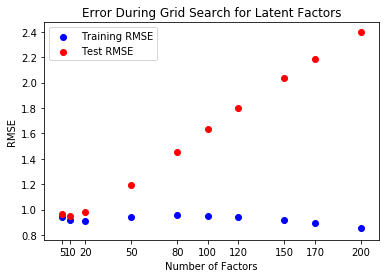

In [127]:
fig, ax = plt.subplots()
ax.scatter(k_option, train_errors, color="b", label='Training RMSE')
ax.scatter(k_option, test_errors, color="r", label='Test RMSE')
ax.set_title("Error During Grid Search for Latent Factors")
ax.set_xlabel("Number of Factors")
ax.set_ylabel("RMSE")
ax.set_xticks([5, 10, 20, 50, 80, 100, 120, 150, 170, 200])
ax.legend()

In [128]:
reg_option = [0.001, 0.01, 0.05, 0.2, 0.5, 1, 1.5]
train_errors = []
test_errors = []
lfm = LFM(train_matrix, test_matrix)
for reg in reg_option:
    lfm.initialize(k=15)
    lr = 0.0000001
    trg_err, test_err = lfm.train(lr, lr, reg, reg, 30)
    train_errors = train_errors + [trg_err]
    test_errors = test_errors + [test_err]
    

current training error: 1.096846365917348
current test error: 1.1996204304109799
Run took 12.32 seconds for epoch 0
current training error: 0.9877536522901001
current test error: 1.06783521402165
Run took 12.30 seconds for epoch 1
current training error: 0.9554294068071754
current test error: 1.0215911355975518
Run took 11.10 seconds for epoch 2
current training error: 0.9445485082101484
current test error: 1.0032455948686096
Run took 11.03 seconds for epoch 3
current training error: 0.9399541575420538
current test error: 0.9947703727179311
Run took 10.89 seconds for epoch 4
current training error: 0.9373794013722951
current test error: 0.9901747031590328
Run took 10.90 seconds for epoch 5
current training error: 0.935528310280352
current test error: 0.9872614479796743
Run took 10.91 seconds for epoch 6
current training error: 0.9339702213259065
current test error: 0.9851415680444106
Run took 10.90 seconds for epoch 7
current training error: 0.9325479555736882
current test error: 0.983

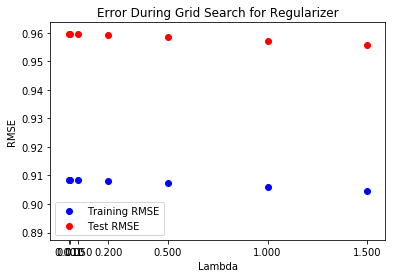

In [132]:
fig, ax = plt.subplots()
ax.scatter(reg_option, train_errors, color="b", label='Training RMSE')
ax.scatter(reg_option, test_errors, color="r", label='Test RMSE')
ax.set_title("Error During Grid Search for Regularizer")
ax.set_xlabel("Lambda")
ax.set_ylabel("RMSE")
ax.set_xticks([0.001, 0.01, 0.05, 0.2, 0.5, 1, 1.5])
ax.legend()

current training error: 1.1075563579338035
current test error: 1.1898352041087452
Run took 12.56 seconds for epoch 0
current training error: 0.9948906974412528
current test error: 1.058966335483747
Run took 11.44 seconds for epoch 1
current training error: 0.961132203808413
current test error: 1.0140513650449892
Run took 11.28 seconds for epoch 2
current training error: 0.9495965066684596
current test error: 0.9965457474531154
Run took 11.07 seconds for epoch 3
current training error: 0.9446408730302854
current test error: 0.9884883484488911
Run took 11.35 seconds for epoch 4
current training error: 0.9418253309798761
current test error: 0.9840543663097401
Run took 10.82 seconds for epoch 5
current training error: 0.9397879257315468
current test error: 0.9811613585651547
Run took 10.90 seconds for epoch 6
current training error: 0.9380706516864998
current test error: 0.9789861711704418
Run took 10.97 seconds for epoch 7
current training error: 0.9365041203732853
current test error: 0.9

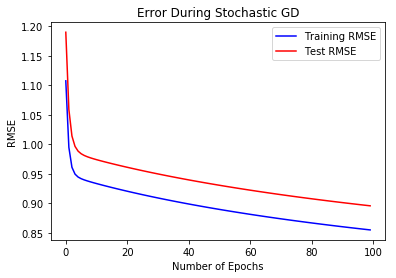

In [175]:
lfm = LFM(train_matrix, test_matrix)
lfm.initialize(k=12)
lr = 0.0000001
reg = 1.5
trg_err, test_err = lfm.train(lr, lr, reg, reg, 100)
lfm.trainplot()

In [176]:
lfm.pred_forall()

In [177]:
lfm.recommend(116, 10)

['Iron Man',
 'Dark Knight, The',
 'No Country for Old Men',
 'Casino Royale',
 'Prestige, The',
 'Children of Men',
 'Departed, The',
 'Little Miss Sunshine',
 'V for Vendetta',
 'King Kong']

In [467]:
pred_rating_lfm = lfm.pred.applymap(lambda x: 1 if x > 2.5 else 0)

In [468]:
true_rating_lfm = test_matrix.fillna(0).applymap(lambda x: 1 if x > 3 else 0)

In [433]:
true_rating_lfm.head()

movieId,1,2,6,10,11,16,19,21,25,32,...,41569,44191,46578,48516,48774,48780,49272,55820,58559,59315
userId,,,,,,,,,,,,,,,,,,,,,
116,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,1,0
298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
359,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [469]:
def recall_lfm(movieid):
    like = pred_rating_lfm[[movieid]][pred_rating_lfm[movieid] == 1].index.tolist()
    real = true_rating_lfm[[movieid]][true_rating_lfm[movieid] == 1].index.tolist()
    correct = len(set(like).intersection(set(real)))
    
    return correct / len(real)

In [470]:
recall = 0
for id in pred_rating_lfm.columns:
    recall += recall_lfm(id)
recall = recall / pred_rating_lfm.shape[1]
print('Recall rate for latent factor model is: ' + str(recall))

Recall rate for latent factor model is: 0.8943642655849149


In [233]:
class LFM_bias(object):
    ''' This class built a recommender system based on latent factor model with 
    stochastic gradient descent'''
    
    def __init__(self, train, test):
        self.ids = train.index
        self.columns = train.columns
        self.R = train.fillna(0).values
        self.T = test.fillna(0).values
        self.Q = None
        self.P = None
    
    def initialize(self, Q=None, P=None, k=1):
        '''initialize Q, P and latent factor k. The default values for Q and P
        are the results for SVD for R'''
        if (Q is not None) and (P is not None):
            self.Q = Q
            self.P = P
        else:
            u, s, vt = svds(self.R, k=k)
            s_diag=np.diag(s)
            self.Q = u
            self.P = s_diag.dot(vt).T
            
    def rmse_(self, R, Q, P, Bx, Bi, mu):
       # prediction = Q.dot(P.T)
       # prediction = prediction[R.nonzero()].flatten() 
       # true_value = R[R.nonzero()].flatten()
       # return math.sqrt(mean_squared_error(prediction, true_value))
        I = R != 0  # Indicator function which is zero for missing data
        ME = I * (R - (Bx + Bi - mu + np.dot(Q, P.T))) # Errors between real and predicted ratings
        MSE = ME**2  
        return np.sqrt(np.sum(MSE)/np.sum(I))
    
    def train(self, lr1, lr2, reg1, reg2, maxiter):
        '''SGD for training
        @lr1: learning rate for Q   @lr2: learning rate for P
        @reg1: regularizer for Q    @reg2: regularizer for P
        @maxiter: stop when epochs exceed this value
        '''
        
        train_errors = []
        test_errors = []
        users,items = self.R.nonzero() 
        for epoch in range(maxiter):
            # Include Bias term
            self.mu = self.R.mean().mean()
            bx = self.R.mean(axis=1)
            bi = self.R.mean(axis=0)
            self.Bx = np.tile(bx, self.R.shape[1]).reshape(self.R.shape[0], self.R.shape[1])
            self.Bi = np.tile(bi, self.R.shape[0]).reshape(self.R.shape[0], self.R.shape[1])
            dR = 2 * (self.R - (self.Bx + self.Bi - self.mu + self.Q.dot(self.P.T)))
            
            start_time = default_timer()
            for u, i in zip(users, items):
                dq = dR[u, i] * self.P[i, :] - 2 * reg2 * self.Q[u, :]
                self.Q[u, :] += lr1 * dq
                dp = dR[u, i] * self.Q[u, :] - 2 * reg1 * self.P[i, :]
                self.P[i, :] += lr2 * dp
            
            trg_err = self.rmse_(self.R, self.Q, self.P, self.Bx, self.Bi, self.mu)
            print("current training error: " + str(trg_err))
            train_errors = train_errors + [trg_err]
            test_err = self.rmse_(self.T, self.Q, self.P, self.Bx, self.Bi, self.mu)
            print("current test error: " + str(test_err))
            test_errors = test_errors + [test_err]
            print("Run took %.2f seconds for epoch " % (default_timer() - start_time) + str(epoch))
        self.train_errors = train_errors
        self.test_errors = test_errors
        return self.train_errors[-1], self.test_errors[-1]
            
    def trainplot(self):
        
        # Check performance by plotting train and test errors
        fig, ax = plt.subplots()
        ax.plot(self.train_errors, color="b", label='Training RMSE')
        ax.plot(self.test_errors, color="r", label='Test RMSE')
        ax.set_title("Error During Stochastic GD")
        ax.set_xlabel("Number of Epochs")
        ax.set_ylabel("RMSE")
        ax.legend()
    def pred_forall(self):
        self.pred = pd.DataFrame(self.Bx + self.Bi - mu + self.Q.dot(self.P.T), index=self.ids, columns=self.columns)

        
    def recommend(self, userid, k):
        '''Input userid to recommend top k movies that this user might like most'''
        
        rec = list(self.pred.loc[userid, :].argsort()[-k:][::-1].index)
        
        return list(map(lambda x: nameDict[x], rec))

In [368]:
k_option = [5, 10, 15, 20]
train_errors = []
test_errors = []
lfm_bias = LFM_bias(train_matrix, test_matrix)
for k in k_option:
    lfm_bias.initialize(k=k)
    lr = 0.0000001
    reg = 1.5
    trg_err, test_err = lfm_bias.train(lr, lr, reg, reg, 30)
    train_errors = train_errors + [trg_err]
    test_errors = test_errors + [test_err]

current training error: 1.1330703918446206
current test error: 1.1387665735262413
Run took 11.68 seconds for epoch 0
current training error: 1.075264057311119
current test error: 1.0896027068099323
Run took 10.92 seconds for epoch 1
current training error: 1.0623089176505196
current test error: 1.0801850228003682
Run took 11.06 seconds for epoch 2
current training error: 1.0586836754863627
current test error: 1.0781117102386557
Run took 11.15 seconds for epoch 3
current training error: 1.0571463686316953
current test error: 1.0773052552463838
Run took 11.10 seconds for epoch 4
current training error: 1.0561287638425412
current test error: 1.0766568014659077
Run took 12.08 seconds for epoch 5
current training error: 1.0552619471334006
current test error: 1.0759920087362131
Run took 12.61 seconds for epoch 6
current training error: 1.0544514650116292
current test error: 1.0753032537800928
Run took 12.04 seconds for epoch 7
current training error: 1.0536709206373869
current test error: 1.

KeyboardInterrupt: 

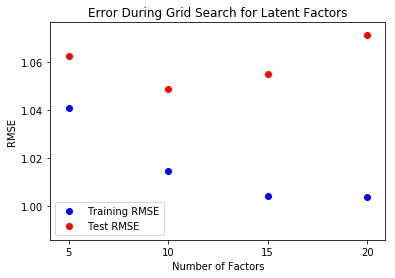

In [373]:
fig, ax = plt.subplots()
ax.scatter(k_option, train_errors, color="b", label='Training RMSE')
ax.scatter(k_option, test_errors, color="r", label='Test RMSE')
ax.set_title("Error During Grid Search for Latent Factors")
ax.set_xlabel("Number of Factors")
ax.set_ylabel("RMSE")
ax.set_xticks(k_option)
ax.legend()

In [408]:
reg_option = [0.5, 1, 1.5, 2.5, 4, 8, 10, 13, 15, 20, 22, 25, 30, 35, 40, 50, 60, 100]
train_errors = []
test_errors = []
lfm_bias = LFM_bias(train_matrix, test_matrix)
for reg in reg_option:
    lfm_bias.initialize(k=10)
    lr = 0.0000001
    trg_err, test_err = lfm_bias.train(lr, lr, reg, reg, 20)
    train_errors = train_errors + [trg_err]
    test_errors = test_errors + [test_err]

current training error: 1.108100081467136
current test error: 1.110953070759422
Run took 13.07 seconds for epoch 0
current training error: 1.0437203460022577
current test error: 1.0651310128218054
Run took 12.73 seconds for epoch 1
current training error: 1.0284276316238417
current test error: 1.057523875894173
Run took 12.70 seconds for epoch 2
current training error: 1.02231003444016
current test error: 1.0546992222162004
Run took 12.29 seconds for epoch 3
current training error: 1.0179533877719016
current test error: 1.0517705594037676
Run took 12.14 seconds for epoch 4
current training error: 1.013978053399014
current test error: 1.0483683635070968
Run took 12.11 seconds for epoch 5
current training error: 1.0101680410969316
current test error: 1.0447131479937743
Run took 11.71 seconds for epoch 6
current training error: 1.0065227050339618
current test error: 1.0410068231103264
Run took 11.72 seconds for epoch 7
current training error: 1.00306735668444
current test error: 1.0373744

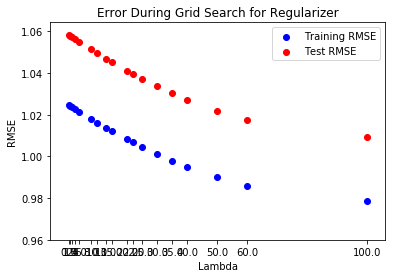

In [412]:
fig, ax = plt.subplots()
ax.scatter(reg_option, train_errors, color="b", label='Training RMSE')
ax.scatter(reg_option, test_errors, color="r", label='Test RMSE')
ax.set_title("Error During Grid Search for Regularizer")
ax.set_xlabel("Lambda")
ax.set_ylabel("RMSE")
ax.set_xticks(reg_option)
ax.legend()

In [377]:
train_temp = train_errors
test_temp = test_errors

current training error: 1.1224509715646722
current test error: 1.122855582420154
Run took 11.57 seconds for epoch 0
current training error: 1.0560021834585722
current test error: 1.0748918717308438
Run took 11.76 seconds for epoch 1
current training error: 1.0401621506636587
current test error: 1.0670629218530854
Run took 11.47 seconds for epoch 2
current training error: 1.0346700344401445
current test error: 1.065139969563929
Run took 11.45 seconds for epoch 3
current training error: 1.0314011293607042
current test error: 1.0635191310613612
Run took 11.56 seconds for epoch 4
current training error: 1.0286481403562904
current test error: 1.0615365657066955
Run took 11.44 seconds for epoch 5
current training error: 1.0260436656752416
current test error: 1.0592809373463103
Run took 11.50 seconds for epoch 6
current training error: 1.0235130692695522
current test error: 1.0568876624671824
Run took 11.48 seconds for epoch 7
current training error: 1.0210452972537172
current test error: 1.0

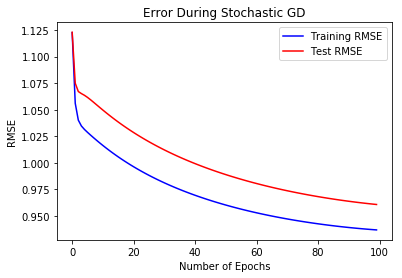

In [417]:
lfm_bias = LFM_bias(train_matrix, test_matrix)
lfm_bias.initialize(k=10)
lr = 0.0000001
reg = 35
trg_err, test_err = lfm_bias.train(lr, lr, reg, reg, 100)
lfm_bias.trainplot()

In [463]:
lfm_bias.pred_forall()

In [464]:
pred_rating_lfm_bias = lfm_bias.pred.applymap(lambda x: 1 if x > 3 else 0)
true_rating_lfm_bias = true_rating_lfm

In [465]:
def recall_lfm_bias(movieid):
    like = pred_rating_lfm_bias[[movieid]][pred_rating_lfm_bias[movieid] == 1].index.tolist()
    real = true_rating_lfm_bias[[movieid]][true_rating_lfm_bias[movieid] == 1].index.tolist()
    correct = len(set(like).intersection(set(real)))
    
    return correct / len(real)

In [466]:
recall = 0
for id in pred_rating_lfm_bias.columns:
    recall += recall_lfm_bias(id)
recall = recall / pred_rating_lfm_bias.shape[1]
print('Recall rate for latent factor model with bias is: ' + str(recall))

Recall rate for latent factor model with bias is: 0.6913188918221584


In [475]:
from surprise import BaselineOnly
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split

In [472]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)

Using ALS


In [477]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(sub_ratings[['userId', 'movieId', 'rating']], reader)
train, test = train_test_split(data, test_size=0.2)

In [478]:
algo.fit(train)

Estimating biases using als...


In [479]:
test = algo.test(test)

In [480]:
test = pd.DataFrame(test)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions', 'details']
test.head()

,userId,movieId,actual,cf_predictions,details
0,66617,2918,3.0,2.994105,{'was_impossible': False}
1,68558,2396,3.5,3.393535,{'was_impossible': False}
2,79366,2006,3.5,3.460250,{'was_impossible': False}
3,137130,1580,4.5,3.814852,{'was_impossible': False}
4,40008,5995,4.5,4.104908,{'was_impossible': False}


In [481]:
rmse(test['actual'], test['cf_predictions'])

0.8153514665857242